In this notebook, we will generate item embeddings from text data that will later serve as representations of user states and actions in our reward simulator and environment.

First, we will examine the text data by analyzing it, performing text preprocessing, and training a custom fastText model.

Second, we will explore pretrained Sentence-BERT embeddings.

Third, we will leverage combined title and abstract entity embeddings provided as part of the MIND dataset.

All embeddings will be saved as lookup tables for later use.

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import pickle
from google.colab import drive
from collections import Counter
import json

from sklearn.metrics import classification_report, log_loss, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder

from yellowbrick.cluster import KElbowVisualizer
from gensim.models import FastText

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir = '/content/drive/MyDrive/ML/Reinforcement Learning/Final project/MIND'

In [ ]:
behaviors_train_path = os.path.join(project_dir, 'MINDsmall_train/behaviors.tsv')

behaviors_train = pd.read_csv(behaviors_train_path, sep='\t', header=None, names=["impression_id", "user_id", "time", "history", "impressions"])

In [ ]:
news_train_path = os.path.join(project_dir, 'MINDsmall_train/news.tsv')

news_train = pd.read_csv(news_train_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

In [ ]:
behaviors_train.head()

,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [ ]:
news_train.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [ ]:
num_articles = news_train['news_id'].nunique()
print(f"Number of unique articles: {num_articles}")

Number of unique articles: 51282


## Look at the text data

In [ ]:
# Check for NaN values in the four columns that would comprise a single text field, from which embeddings would be generated

news_train[["category", "subcategory", "title", "abstract"]].isna().sum()

,0
category,0
subcategory,0
title,0
abstract,2666


In [ ]:
# Replace NaN values in the abstract column with empty strings

news_train["abstract"] = news_train["abstract"].fillna("")
(news_train[["abstract"]] == "").sum()

,0
abstract,2666


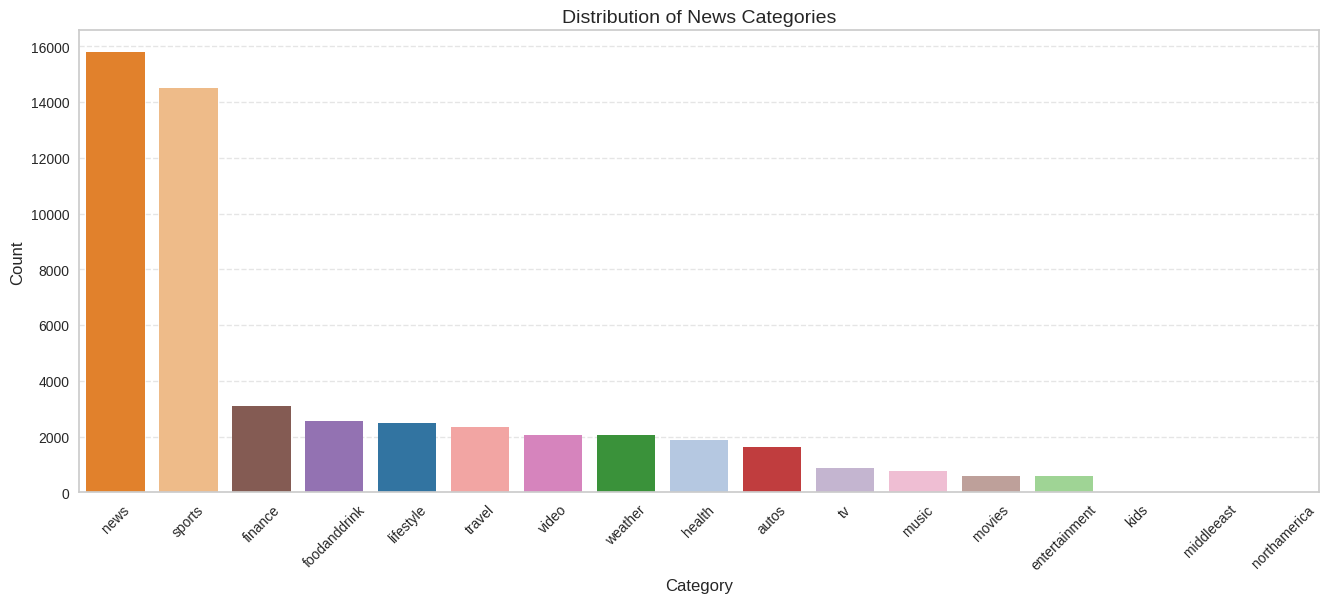

In [ ]:
plt.figure(figsize=(16, 6))
sns.countplot(data=news_train, x="category", hue="category", order=news_train["category"].value_counts().index, palette="tab20")

plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of News Categories", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

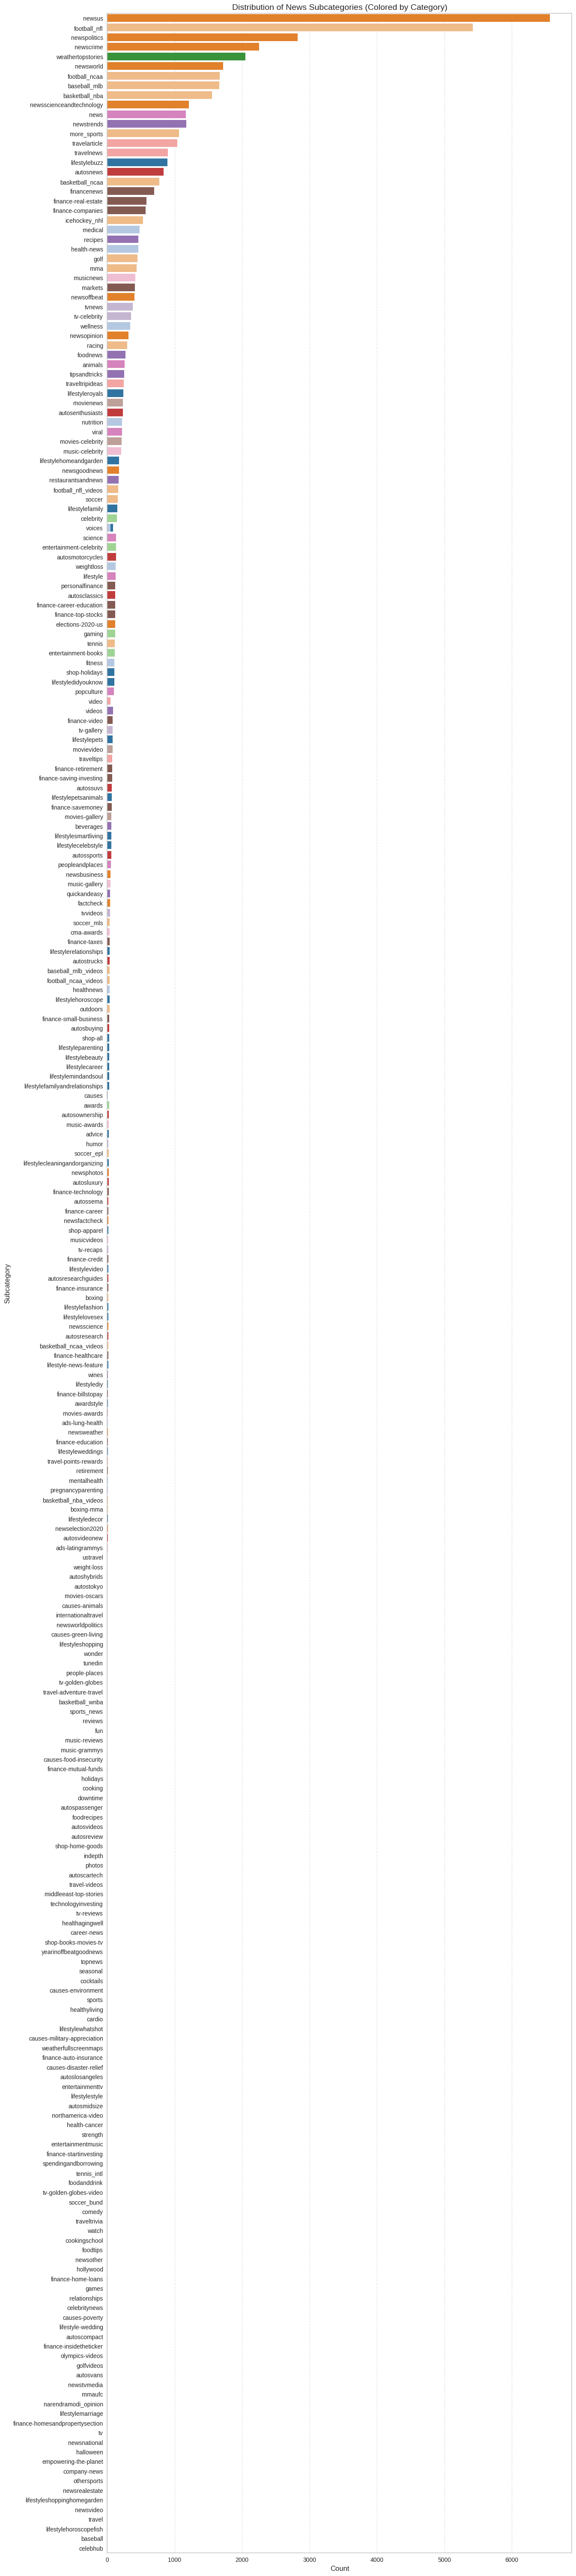

In [ ]:
category_palette = dict(zip(news_train["category"].unique(), sns.color_palette("tab20", n_colors=news_train["category"].nunique())))

plt.figure(figsize=(14, 77))
sns.countplot(
    data=news_train,
    y="subcategory",
    order=news_train["subcategory"].value_counts().index,
    hue="category",
    palette=category_palette,
    dodge=False,
    legend=False
)

plt.xlabel("Count", fontsize=12)
plt.ylabel("Subcategory", fontsize=12)
plt.title("Distribution of News Subcategories (Colored by Category)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

In [ ]:
news_train['len_title'] = news_train['title'].apply(lambda x: len(x))
news_train['len_abstract'] = news_train['abstract'].apply(lambda x: len(x))

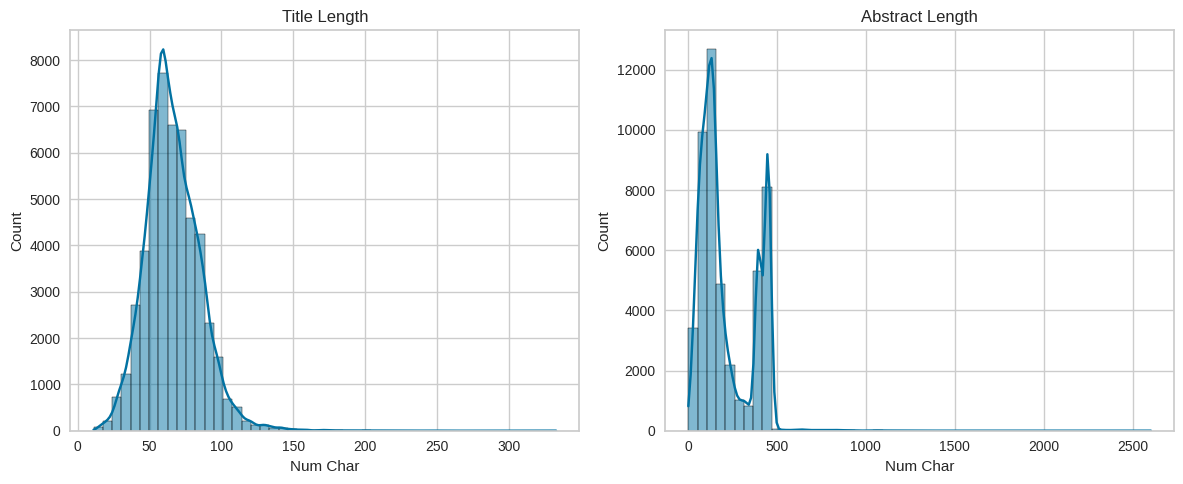

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(news_train['len_title'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Title Length")
axes[0].set_xlabel("Num Char")

sns.histplot(news_train[news_train['len_abstract'] > 0]['len_abstract'], bins=50, kde=True, ax=axes[1]) # Filter out samples with no abstracts
axes[1].set_title("Abstract Length")
axes[1].set_xlabel("Num Char")

plt.tight_layout()
plt.show()

## Embedding text data

Given that our dataset contains many distinct categories and an extensive number of subcategories—both of which are highly imbalanced—we will merge the "category", "subcategory", "title", and "abstract" columns into a single text feature. Additionally, we will further process the subcategory column.

In [ ]:
def preprocess_subcategory(category, subcategory):

    if '-' in subcategory or '_' in subcategory:
        subcategory = subcategory.replace('-', ' ').replace('_', ' ')
        return subcategory

    if category.lower() in subcategory.lower():
        return ''
    else:
        return subcategory

In [ ]:
news_train['proc_subcategory'] = news_train.apply(lambda row: preprocess_subcategory(row['category'], row['subcategory']), axis=1)

In [ ]:
news_train["text"] = news_train["category"] + " "\
+ news_train["proc_subcategory"] + " "\
+ news_train["title"] + " "\
+ news_train["abstract"]

### Approach 1: Train a custom FastText model with embedding size = 64

In [ ]:
stop_words = set(stopwords.words('english')) | set(ENGLISH_STOP_WORDS) | {"n't", "'ll", "'m", "'re", "'s", "'ve", "'d", "'t", "wo", "ca"}

In [ ]:
len(stop_words)

407

In [ ]:
def preprocess_text(text):

    text = text.lower()

    # Replace multiple whitespace characters with a single space.
    text = re.sub(r'\s+', ' ', text)

    # Remove standalone numbers from the text.
    text = re.sub(r'\b\d+\b', '', text)

    # Remove punctuation from the text.
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text into individual words.
    tokens = word_tokenize(text)

    # Remove stop words from the tokens.
    tokens = [word for word in tokens if word not in stop_words]

    # Remove duplicate tokens by converting the list to a set, then back to a list.
    tokens = list(set(tokens))

    return tokens

In [ ]:
news_train['clean_text'] = news_train['text'].apply(preprocess_text)

In [ ]:
# Take a look at a single example

print(f"Before processing: {news_train['text'].iloc[0]}")
print(f"After processing: {news_train['clean_text'].iloc[0]}")

Before processing: lifestyle  The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By Shop the notebooks, jackets, and more that the royals can't live without.
After processing: ['notebooks', 'prince', 'live', 'jackets', 'lifestyle', 'royals', 'brands', 'elizabeth', 'shop', 'queen', 'swear', 'charles', 'philip']


In [ ]:
news_train['len_tokens'] = news_train['clean_text'].apply(lambda x: len(x))

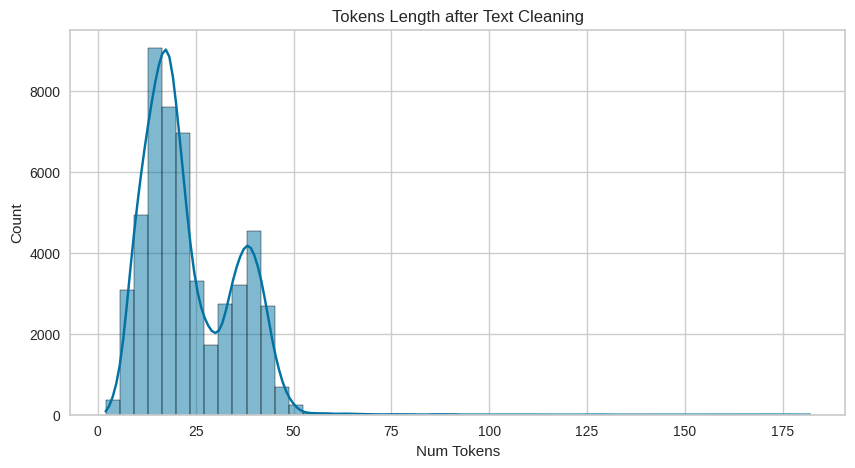

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(news_train['len_tokens'], bins=50, kde=True)
plt.xlabel("Num Tokens")
plt.title("Tokens Length after Text Cleaning")
plt.show()

In [ ]:
ft_model = FastText(vector_size=64, window=3, min_count=3)
ft_model.build_vocab(corpus_iterable = news_train['clean_text'])

In [ ]:
# Let's take a closer look at vocab

vocab = ft_model.wv
vocabulary_words = list(vocab.key_to_index.keys())

In [ ]:
len(vocabulary_words)

26602

In [ ]:
vocabulary_words[:10]

['news',
 'sports',
 'football',
 'new',
 'nfl',
 'said',
 'week',
 'video',
 'finance',
 'state']

In [ ]:
# Train the model

ft_model.train(corpus_iterable=news_train['clean_text'], total_examples=len(news_train), epochs=10)

(11108162, 11891470)

In [ ]:
# Save and then load the model if you need it. But we will save the embeddings as look-up tables later on.

# ft_model.save(os.path.join(project_dir, 'fasttext_model.bin'))
# ft_model = FastText.load(os.path.join(project_dir, 'fasttext_model.bin'))

In [ ]:
# Let's perform a couple of sanity checks. We expect the model to correctly compute similarity.

ft_model.wv.most_similar(positive=['politics'])

[('politicians', 0.9496366381645203),
 ('politician', 0.9417118430137634),
 ('politico', 0.91563481092453),
 ('bidens', 0.8694944977760315),
 ('political', 0.8271897435188293),
 ('politically', 0.8268389105796814),
 ('script', 0.8257989287376404),
 ('tantrum', 0.807505190372467),
 ('polite', 0.805824339389801),
 ('criticisms', 0.8046543002128601)]

In [ ]:
ft_model.wv.most_similar(positive=['football'])

[('nonfootball', 0.9850237965583801),
 ('footballs', 0.9776239991188049),
 ('foottall', 0.8295053243637085),
 ('softball', 0.8056314587593079),
 ('fastball', 0.8044103980064392),
 ('mccall', 0.7719316482543945),
 ('tall', 0.7597216963768005),
 ('footsteps', 0.7555818557739258),
 ('fonseca', 0.7343831062316895),
 ('steelers', 0.72184157371521)]

In [ ]:
ft_model.wv.most_similar(positive=['health'])

[('healthier', 0.9508264660835266),
 ('adventhealth', 0.9402221441268921),
 ('stealth', 0.918106734752655),
 ('healthiest', 0.9174091815948486),
 ('wealth', 0.9166849255561829),
 ('healthy', 0.8889356851577759),
 ('healthcare', 0.8826209306716919),
 ('heals', 0.8787828683853149),
 ('unhealthy', 0.8706652522087097),
 ('heal', 0.8520520925521851)]

In [ ]:
ft_model.wv.most_similar(positive=['life'])

[('metlife', 0.9340057969093323),
 ('worklife', 0.8983386158943176),
 ('nonlife', 0.8468645811080933),
 ('lift', 0.8027626276016235),
 ('couple', 0.7993512749671936),
 ('jewelry', 0.7955169677734375),
 ('thoughtful', 0.7935664057731628),
 ('lifeline', 0.7880817651748657),
 ('lifespan', 0.771673321723938),
 ('hair', 0.7686383724212646)]

In [ ]:
ft_model.wv.most_similar(positive=['royal'])

[('royale', 0.9245925545692444),
 ('royalty', 0.8902304172515869),
 ('royals', 0.8661888241767883),
 ('fashion', 0.8512882590293884),
 ('loyal', 0.8453771471977234),
 ('memoir', 0.8090984225273132),
 ('outfit', 0.8082901835441589),
 ('choice', 0.7994986772537231),
 ('lifetimes', 0.7909703850746155),
 ('ip', 0.7819576263427734)]

In [ ]:
ft_model.wv.most_similar(positive=['trump'])

[('extrump', 0.9767221808433533),
 ('antitrump', 0.9636061787605286),
 ('trumpian', 0.949237585067749),
 ('protrump', 0.9253204464912415),
 ('trumper', 0.921794593334198),
 ('lump', 0.9079208970069885),
 ('trumpukraine', 0.8980827927589417),
 ('grumpy', 0.8542097210884094),
 ('tantrum', 0.800534725189209),
 ('truman', 0.7853618264198303)]

In [ ]:
# Define a function to compute the mean embedding for an article's tokens using the given model

def get_mean_embedding(tokens, model):
    return np.mean([model.wv[token] for token in tokens], axis=0)

In [ ]:
news_train['fasttext_embedding'] = news_train['clean_text'].apply(lambda x: get_mean_embedding(x, ft_model))

In [ ]:
news_train.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,len_title,len_abstract,proc_subcategory,text,clean_text,len_tokens,fasttext_embedding
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],70,73,,"lifestyle The Brands Queen Elizabeth, Prince ...","[notebooks, prince, live, jackets, lifestyle, ...",13,"[-0.07770192, 0.033218887, -0.6607129, -1.4052..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",29,116,weightloss,health weightloss 50 Worst Habits For Belly Fa...,"[worst, keeping, belly, harmless, weightloss, ...",13,"[0.80361557, 0.30432677, -0.19344966, -1.39305..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",63,196,,news The Cost of Trump's Aid Freeze in the Tr...,"[snipers, perforated, bags, trenches, parapet,...",24,"[0.34488556, 0.12678091, -0.17488778, -0.78129..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",59,99,voices,health voices I Was An NBA Wife. Here's How It...,"[voices, wife, affected, mental, like, fact, n...",15,"[0.6660759, -0.035017513, -0.40881723, -2.2706..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",57,179,medical,"health medical How to Get Rid of Skin Tags, Ac...","[readers, rid, medical, ignore, harmless, appe...",17,"[0.65763646, 0.4013865, 0.21657641, -1.4635266..."


Let's estimate the quality of the resulting embeddings.

In [ ]:
fasttext_embeddings = np.vstack(news_train['fasttext_embedding'].values)

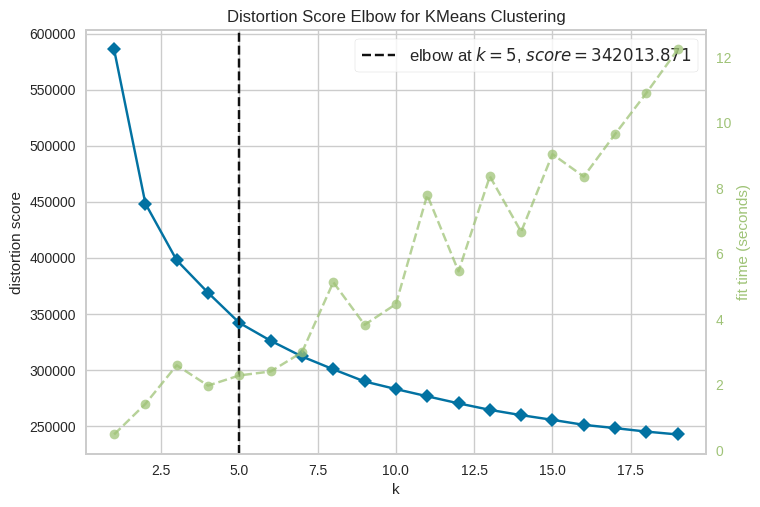

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(init = 'k-means++', n_init=10, random_state=97)
visualizer = KElbowVisualizer(model, k = (1, 20))
visualizer.fit(fasttext_embeddings)
visualizer.show()

In [ ]:
n_clusters = 5

kmeans_model = KMeans(n_init=10, n_clusters=n_clusters, random_state=97)
kmeans_model.fit(fasttext_embeddings)

KMeans(n_clusters=5, n_init=10, random_state=97)

In [ ]:
silhouette_sc = silhouette_score(fasttext_embeddings, kmeans_model.labels_)
davies_bouldin_sc = davies_bouldin_score(fasttext_embeddings, kmeans_model.labels_)
calinski_harabasz_sc = calinski_harabasz_score(fasttext_embeddings, kmeans_model.labels_)

In [ ]:
print(f'Silhouette Score: {silhouette_sc}')
print(f'Davies-Bouldin Index: {davies_bouldin_sc}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_sc}')

Silhouette Score: 0.15269947052001953
Davies-Bouldin Index: 1.766337767240128
Calinski-Harabasz Index: 9144.443063426963


In [ ]:
tsne = TSNE(n_components = 2, random_state = 88)
X_tsne = tsne.fit_transform(fasttext_embeddings)

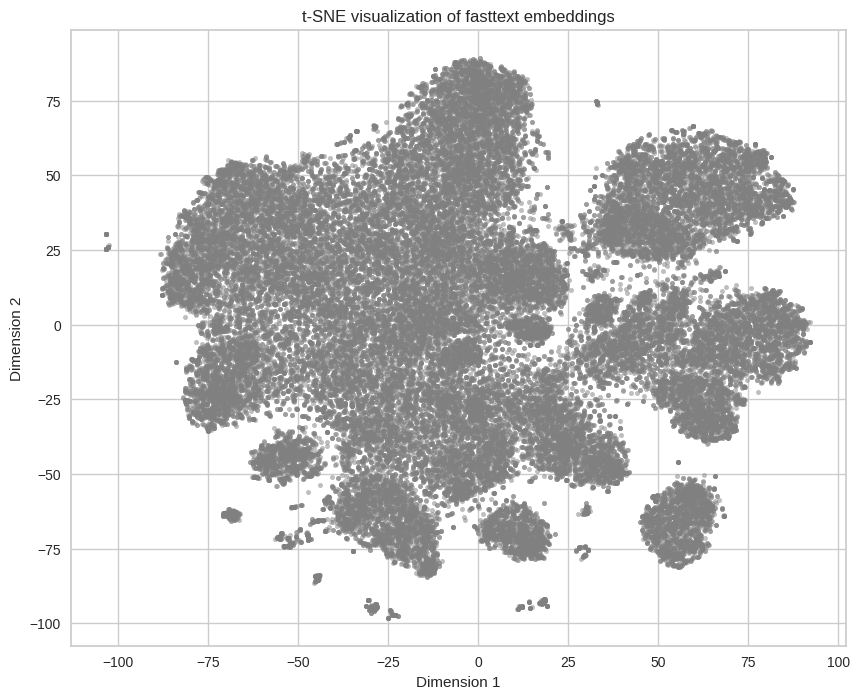

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns = ['Dim1', 'Dim2'])

plt.figure(figsize = (10, 8))
plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c = 'grey', s = 10, alpha = 0.5)
plt.title('t-SNE visualization of fasttext embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

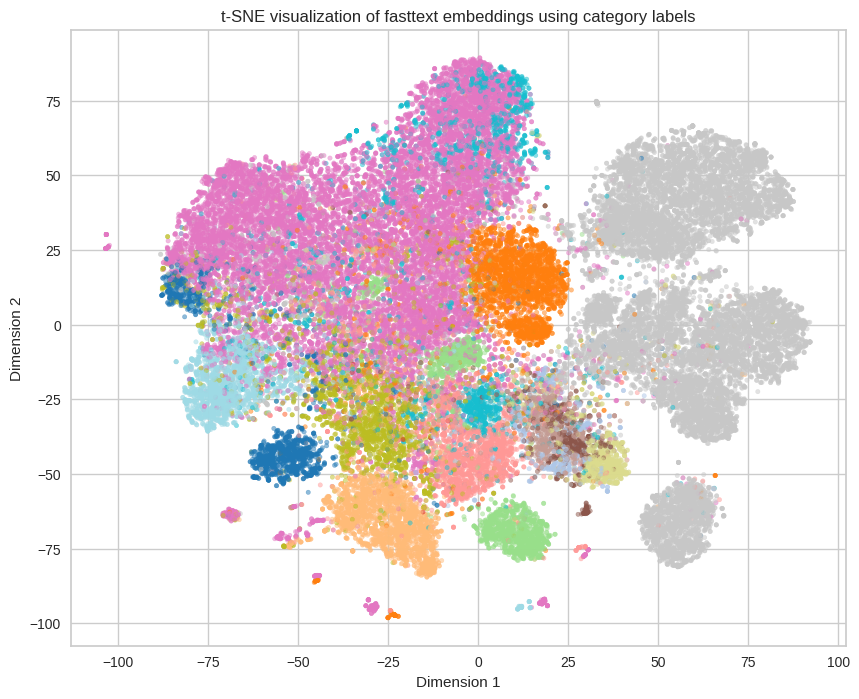

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns = ['Dim1', 'Dim2'])
df_tsne['category'] = news_train['category'].values

label_encoder = LabelEncoder()
df_tsne['category_encoded'] = label_encoder.fit_transform(df_tsne['category'])

plt.figure(figsize = (10, 8))
plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c=df_tsne['category_encoded'], cmap='tab20', s=10, alpha=0.5)
plt.title('t-SNE visualization of fasttext embeddings using category labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

We can see that the model is able to clearly distinguish some of the news categories and also identifies several well-defined clusters that could represent subcategories.

In [ ]:
# Save to a pickle file

# embeddings_path = os.path.join(project_dir, 'news_train_fasttext_embeddings.pkl')

# with open(embeddings_path, 'wb') as f:
#     pickle.dump(news_train[['news_id', 'fasttext_embedding']], f)

In [ ]:
# Load from pickle to check if it works
# with open(embeddings_path, 'rb') as f:
#     ft_emb = pickle.load(f)

Generate the same embeddings for news dev dataset.

In [ ]:
news_dev_path = os.path.join(project_dir, 'MINDsmall_dev/news.tsv')

news_dev = pd.read_csv(news_dev_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

In [ ]:
news_dev["abstract"] = news_dev["abstract"].fillna("")
news_dev['proc_subcategory'] = news_dev.apply(lambda row: preprocess_subcategory(row['category'], row['subcategory']), axis=1)

news_dev["text"] = news_dev["category"] + " "\
+ news_dev["proc_subcategory"] + " "\
+ news_dev["title"] + " "\
+ news_dev["abstract"]

news_dev['clean_text'] = news_dev['text'].apply(preprocess_text)
news_dev['fasttext_embedding'] = news_dev['clean_text'].apply(lambda x: get_mean_embedding(x, ft_model))

In [ ]:
# embeddings_path = os.path.join(project_dir, 'news_dev_fasttext_embeddings.pkl')

# with open(embeddings_path, 'wb') as f:
#     pickle.dump(news_dev[['news_id', 'fasttext_embedding']], f)

In [ ]:
# Load from pickle to check if it works
# with open(embeddings_path, 'rb') as f:
#     ft_emb = pickle.load(f)

### Approach 2: Use pre-trained SentenceBERT embeddings to get rich text representations

In [ ]:
# Load BERT model and tokenizer
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Compute BERT embeddings for the input text
def get_bert_embedding(text, tokenizer, model):
    with torch.no_grad():
        # Tokenize and encode the text with padding and truncation
        inputs = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
        # Move tensors to the appropriate device
        inputs = {key: val.to(device) for key, val in inputs.items()}
        # Pass inputs through the model to obtain outputs
        outputs = model(**inputs)
        # Extract and return the [CLS] token embedding as a NumPy array
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

In [ ]:
embeddings = []
for text in tqdm(news_train["text"].fillna(""), desc="Generating BERT embeddings"):
    embedding = get_bert_embedding(text, tokenizer, model)
    embeddings.append(embedding)

Generating BERT embeddings: 100%|██████████| 51282/51282 [05:11<00:00, 164.45it/s]


In [ ]:
news_train["bert_embedding"] = embeddings

# embeddings_path = os.path.join(project_dir, "news_train_bert_embeddings.pkl")

# with open(embeddings_path, "wb") as f:
#     pickle.dump(news_train[["news_id", "bert_embedding"]], f)

In [ ]:
news_train.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,proc_subcategory,text,bert_embedding
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],,"lifestyle The Brands Queen Elizabeth, Prince ...","[-0.19750953, 0.27611628, 0.40301588, -0.05768..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",weightloss,health weightloss 50 Worst Habits For Belly Fa...,"[0.23216379, 0.4291959, 0.07022456, 0.5814593,..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",,news The Cost of Trump's Aid Freeze in the Tr...,"[0.0037648175, 0.2993399, 0.19800846, 0.141441..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",voices,health voices I Was An NBA Wife. Here's How It...,"[0.14537542, 0.23353784, -0.116760075, -0.1500..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",medical,"health medical How to Get Rid of Skin Tags, Ac...","[0.014690003, 0.44707155, -0.057709374, 0.0908..."


In [ ]:
np.max(embeddings[0]) # Normalization might be needed later.

5.9582725

Generate the same embeddings for news dev dataset.

In [ ]:
news_dev_path = os.path.join(project_dir, 'MINDsmall_dev/news.tsv')

news_dev = pd.read_csv(news_dev_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

In [ ]:
news_dev["abstract"] = news_dev["abstract"].fillna("")
news_dev['proc_subcategory'] = news_dev.apply(lambda row: preprocess_subcategory(row['category'], row['subcategory']), axis=1)

news_dev["text"] = news_dev["category"] + " "\
+ news_dev["proc_subcategory"] + " "\
+ news_dev["title"] + " "\
+ news_dev["abstract"]

In [ ]:
embeddings = []
for text in tqdm(news_dev["text"].fillna(""), desc="Generating BERT embeddings"):
    embedding = get_bert_embedding(text, tokenizer, model)
    embeddings.append(embedding)

Generating BERT embeddings: 100%|██████████| 42416/42416 [03:53<00:00, 181.68it/s]


In [ ]:
news_dev["bert_embedding"] = embeddings

# embeddings_path = os.path.join(project_dir, "news_dev_bert_embeddings.pkl")

# with open(embeddings_path, "wb") as f:
#     pickle.dump(news_dev[["news_id", "bert_embedding"]], f)

### Approach 3: Extract entity_embedding.vec embeddings

In [ ]:
def extract_wikidata_ids(entity_list):
    """
    Extracts Wikidata IDs from a list of entity dictionaries.
    If the entity_list is empty or malformed, returns an empty list.
    """
    try:
        entities = json.loads(entity_list)
        return [entity["WikidataId"] for entity in entities if "WikidataId" in entity]
    except (json.JSONDecodeError, TypeError):
        return []

In [ ]:
news_train.isna().sum()

,0
news_id,0
category,0
subcategory,0
title,0
abstract,0
url,0
title_entities,3
abstract_entities,4


In [ ]:
news_train["title_wikidata_ids"] = news_train["title_entities"].fillna("[]").apply(extract_wikidata_ids)
news_train["abstract_wikidata_ids"] = news_train["abstract_entities"].fillna("[]").apply(extract_wikidata_ids)

In [ ]:
news_train[['title_wikidata_ids', 'abstract_wikidata_ids']].head()

,title_wikidata_ids,abstract_wikidata_ids
0,"[Q80976, Q43274, Q9682]",[]
1,[Q193583],[Q193583]
2,[],[Q212]
3,[],[Q155223]
4,[Q3179593],"[Q3179593, Q171171, Q371820]"


In [ ]:
news_train['title_wikidata_ids_len'] = news_train['title_wikidata_ids'].apply(lambda x: len(x))
news_train['abstract_wikidata_ids_len'] = news_train['abstract_wikidata_ids'].apply(lambda x: len(x))

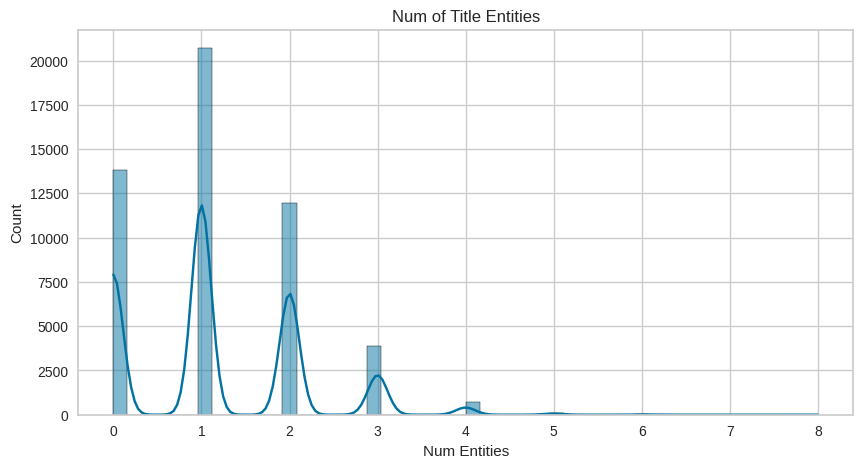

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(news_train['title_wikidata_ids_len'], bins=50, kde=True)
plt.xlabel("Num Entities")
plt.title("Num of Title Entities")
plt.show()

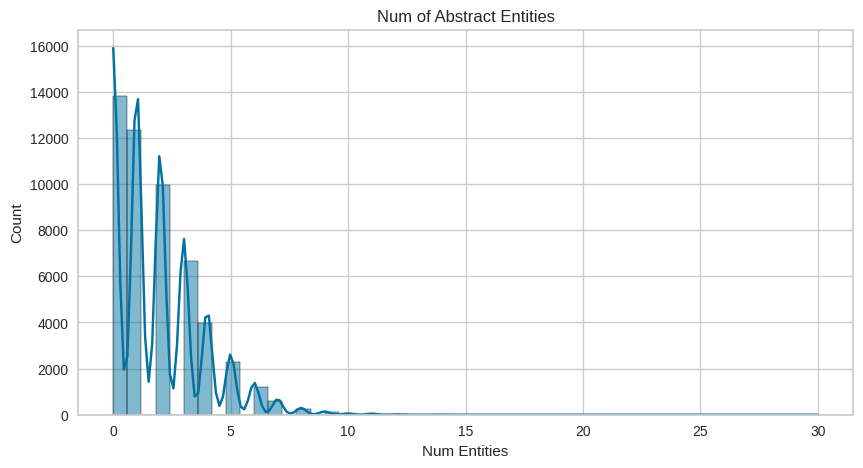

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(news_train['abstract_wikidata_ids_len'], bins=50, kde=True)
plt.xlabel("Num Entities")
plt.title("Num of Abstract Entities")
plt.show()

In [ ]:
def load_entity_embeddings(filepath):
    entity_embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            entity = parts[0]  # Entity ID (assuming first column is entity)
            vector = np.array(parts[1:], dtype=np.float32)  # Embedding vector
            entity_embeddings[entity] = vector
    return entity_embeddings

In [ ]:
entity_emb_path = os.path.join(project_dir, 'MINDsmall_train/entity_embedding.vec')
relation_emb_path = os.path.join(project_dir, 'MINDsmall_train/relation_embedding.vec')

In [ ]:
entity_embeddings = load_entity_embeddings(entity_emb_path)
relation_embeddings = load_entity_embeddings(relation_emb_path)

In [ ]:
def get_entity_embedding(entity_ids, entity_embeddings, embedding_dim=100):
    """Retrieve entity embeddings and take mean if multiple entities exist."""
    valid_embeddings = [entity_embeddings[eid] for eid in entity_ids if eid in entity_embeddings]

    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0)  # Average if multiple
    else:
        return np.zeros(embedding_dim)  # Zero vector if no entity found

In [ ]:
title_entity_vectors = []
abstract_entity_vectors = []

for _, row in tqdm(news_train.iterrows(), total=len(news_train), desc="Extracting entity embeddings"):
    # Get embeddings for title and abstract entities
    title_vector = get_entity_embedding(row["title_wikidata_ids"], entity_embeddings)
    abstract_vector = get_entity_embedding(row["abstract_wikidata_ids"], entity_embeddings)

    # Store results
    title_entity_vectors.append(title_vector)
    abstract_entity_vectors.append(abstract_vector)

Extracting entity embeddings: 100%|██████████| 51282/51282 [00:05<00:00, 9263.30it/s]


In [ ]:
title_entity_vectors = np.array(title_entity_vectors)
abstract_entity_vectors = np.array(abstract_entity_vectors)

# Create a final 200-dimensional entity embedding per article
news_train["entity_embedding"] = list(np.hstack((title_entity_vectors, abstract_entity_vectors)))

In [ ]:
news_train.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,title_wikidata_ids,abstract_wikidata_ids,title_wikidata_ids_len,abstract_wikidata_ids_len,entity_embedding
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[Q80976, Q43274, Q9682]",[],3,0,"[0.004057333339005709, -0.03991733118891716, -..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",[Q193583],[Q193583],1,1,"[-0.013597000390291214, -0.009758000262081623,..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],[Q212],0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],[Q155223],0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",[Q3179593],"[Q3179593, Q171171, Q371820]",1,3,"[0.01425699982792139, 0.018350999802350998, 0...."


In [ ]:
news_dev_path = os.path.join(project_dir, 'MINDsmall_dev/news.tsv')
news_dev = pd.read_csv(news_dev_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

In [ ]:
news_dev["title_wikidata_ids"] = news_dev["title_entities"].fillna("[]").apply(extract_wikidata_ids)
news_dev["abstract_wikidata_ids"] = news_dev["abstract_entities"].fillna("[]").apply(extract_wikidata_ids)

In [ ]:
entity_emb_path = os.path.join(project_dir, 'MINDsmall_dev/entity_embedding.vec')
entity_embeddings = load_entity_embeddings(entity_emb_path)

title_entity_vectors = []
abstract_entity_vectors = []

for _, row in tqdm(news_dev.iterrows(), total=len(news_dev), desc="Extracting entity embeddings"):
    # Get embeddings for title and abstract entities
    title_vector = get_entity_embedding(row["title_wikidata_ids"], entity_embeddings)
    abstract_vector = get_entity_embedding(row["abstract_wikidata_ids"], entity_embeddings)

    # Store results
    title_entity_vectors.append(title_vector)
    abstract_entity_vectors.append(abstract_vector)

title_entity_vectors = np.array(title_entity_vectors)
abstract_entity_vectors = np.array(abstract_entity_vectors)

# Create a final 200-dimensional entity embedding per article
news_dev["entity_embedding"] = list(np.hstack((title_entity_vectors, abstract_entity_vectors)))

Extracting entity embeddings: 100%|██████████| 42416/42416 [00:04<00:00, 10066.79it/s]


In [ ]:
news_dev.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,title_wikidata_ids,abstract_wikidata_ids,entity_embedding
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[Q80976, Q43274, Q9682]",[],"[0.004057333339005709, -0.03991733118891716, -..."
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[],[Q622899],[],"[0.06395599991083145, 0.003074999898672104, -0..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],[Q212],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],[Q155223],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",[Q3179593],"[Q3179593, Q171171, Q371820]","[0.01425699982792139, 0.018350999802350998, 0...."


In [ ]:
# embeddings_path = os.path.join(project_dir, "news_train_entity_embeddings.pkl")

# with open(embeddings_path, "wb") as f:
#     pickle.dump(news_train[["news_id", "entity_embedding"]], f)

In [ ]:
# embeddings_path = os.path.join(project_dir, "news_dev_entity_embeddings.pkl")

# with open(embeddings_path, "wb") as f:
#     pickle.dump(news_dev[["news_id", "entity_embedding"]], f)